In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import gc
import os
from torch.utils.data import DataLoader, random_split, Dataset
import torch.nn as nn
import math
from torch.optim import Adam
from tqdm import tqdm
from Datasets import *
from models import *
from torchvision.models import ResNet50_Weights
from torchgeo.models import resnet18, resnet50, get_weight
from typing import List
from prefetch_generator import BackgroundGenerator
import torch.nn.functional as F
from i2sb.runner import Runner
from rasterio.plot import show

SEED = 1234
torch.manual_seed(SEED)
np.random.seed(SEED)

# Optional (for reproducibility in CUDA):
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

/Users/evanwu/ml-mangrove/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


We test our final ResNet UNet Diffusion model after having:
1. Trained our diffusion layer on NAIP data
2. Tuned our decoder layer on 1m/pixel drone data

In [2]:
LOSS = JaccardLoss()
if torch.cuda.is_available():
    DEVICE = torch.device("cuda")
    print("Using CUDA device.")
elif torch.backends.mps.is_available():
    DEVICE = torch.device("mps")
    print("Using Apple Metal Performance Shaders (MPS) device.\n")
else:
    DEVICE = torch.device("cpu")
    print("WARNING: No GPU found. Defaulting to CPU.")

PRETRAINED_CENTER_DECODER_0_WEIGHT_FIRST_VALUE = 0.6512
PRETRAINED_RGB_MOCO_WEIGHT_FIRST_VALUE = 0.0596
PRETRAINED_ALL_MOCO_WEIGHT_FIRST_VALUE = 0.0150

# RGB and Satellite metrics
RGB_MEANS = [0.485, 0.456, 0.406]
RGB_SDS = [0.229, 0.224, 0.225]
'''
SATELLITE_MEANS, SATELLITE_SDS = calculate_band_stats(LIST_TILED_SATELLITE_FILE)
SATELLITE_SDS[10] = 1e-6 # So we don't get divide by 0 error during normalization
print(f"SATELLITE_MEANS: {SATELLITE_MEANS}")
print(f"SATELLITE_SDS: {SATELLITE_SDS}")
'''
SATELLITE_MEANS = [0.026770996230905415, 0.09145129995394104, 0.1374701370800858, 0.12629982008698087, 0.08348537283615888, 0.15234747745903673, 0.1755682088182016, 0.19574084608396258, 0.1958724138455955, 0.19676238458042725, 0.0, 0.15115207971951478, 0.0945010388495151]
SATELLITE_SDS = [0.035945900674540114, 0.09533489898570938, 0.1089656215582545, 0.11637876785009475, 0.0598930857979902, 0.10018866040486654, 0.11469476295117267, 0.1271611062494966, 0.1263377774611167, 0.12642673147611674, 1e-06, 0.11149914947615584, 0.07974405349672085]

# reshape and remake means/sds arrays into tensors
RGB_MEANS_TENSOR = torch.tensor(RGB_MEANS, dtype=torch.float32).view(3, 1, 1).to(DEVICE)
RGB_SDS_TENSOR = torch.tensor(RGB_SDS, dtype=torch.float32).view(3, 1, 1).to(DEVICE)
SATELLITE_MEANS_TENSOR = torch.tensor(SATELLITE_MEANS, dtype=torch.float32).view(13, 1, 1).to(DEVICE)
SATELLITE_SDS_TENSOR = torch.tensor(SATELLITE_SDS, dtype=torch.float32).view(13, 1, 1).to(DEVICE)

INTERVAL = 100

# saved weights from runner (we want the diffusion layer weights specifically)
# contains [net, ema, optimizer, sched] weights
RUNNER_CKPT_PATH = '/Users/evanwu/ml-mangrove/Super Resolution/Schrodinger Diffusion/results/test/model_001000.pt'
RUNNER_CKPT = torch.load(RUNNER_CKPT_PATH, map_location=DEVICE)
print(f"RUNNER_CKPT.keys()={RUNNER_CKPT.keys()}")

# saved weights from decoder tuning
TUNED_DECODER_CKPT_PATH = '/Users/evanwu/Downloads/finat3_200.pth'
TUNED_DECODER_CKPT = torch.load(TUNED_DECODER_CKPT_PATH, map_location=DEVICE)
print(f"TUNED_DECODER_CKPT.keys()={TUNED_DECODER_CKPT.keys()}")

# saved weights from pretrained
CENTER_PATH = '/Users/evanwu/Downloads/224_moco_resnet18_noskip.pth'
CENTER = torch.load(CENTER_PATH, map_location=DEVICE)
print(f"CENTER.keys()={CENTER.keys()}")

OM_SATELLITE_PATH = '/Users/evanwu/ml-mangrove/Super Resolution/Schrodinger Diffusion/data/one_meter_drone/224img_norm_satellite.npy'
OM_LABEL_PATH = '/Users/evanwu/ml-mangrove/Super Resolution/Schrodinger Diffusion/data/one_meter_drone/224img_label.npy'

Using Apple Metal Performance Shaders (MPS) device.

RUNNER_CKPT.keys()=dict_keys(['net', 'ema', 'optimizer', 'sched'])
TUNED_DECODER_CKPT.keys()=odict_keys(['encoder.0.weight', 'encoder.1.weight', 'encoder.1.bias', 'encoder.1.running_mean', 'encoder.1.running_var', 'encoder.1.num_batches_tracked', 'encoder.4.0.conv1.weight', 'encoder.4.0.bn1.weight', 'encoder.4.0.bn1.bias', 'encoder.4.0.bn1.running_mean', 'encoder.4.0.bn1.running_var', 'encoder.4.0.bn1.num_batches_tracked', 'encoder.4.0.conv2.weight', 'encoder.4.0.bn2.weight', 'encoder.4.0.bn2.bias', 'encoder.4.0.bn2.running_mean', 'encoder.4.0.bn2.running_var', 'encoder.4.0.bn2.num_batches_tracked', 'encoder.4.1.conv1.weight', 'encoder.4.1.bn1.weight', 'encoder.4.1.bn1.bias', 'encoder.4.1.bn1.running_mean', 'encoder.4.1.bn1.running_var', 'encoder.4.1.bn1.num_batches_tracked', 'encoder.4.1.conv2.weight', 'encoder.4.1.bn2.weight', 'encoder.4.1.bn2.bias', 'encoder.4.1.bn2.running_mean', 'encoder.4.1.bn2.running_var', 'encoder.4.1.bn2.nu

In [4]:
from utils import JupyterArgParser
from pathlib import Path

# ========= global settings =========
# Taken from i2sb paper with minor changes

RESULT_DIR = Path("results")

# --------------- basic ---------------
parser = JupyterArgParser()
parser.add_argument("--seed",           type=int,   default=0)
parser.add_argument("--name",           type=str,   default=None,        help="experiment ID")
parser.add_argument("--ckpt",           type=str,   default=None,        help="resumed checkpoint name")
parser.add_argument("--device",         type=str,   default=DEVICE,      help="type of device to use for training")
parser.add_argument("--gpu",            type=int,   default=None,        help="set only if you wish to run on a particular GPU")

# --------------- model ---------------
parser.add_argument("--image-size",     type=int,   default=224)
parser.add_argument("--t0",             type=float, default=1e-4,        help="sigma start time in network parametrization")
parser.add_argument("--T",              type=float, default=1.,          help="sigma end time in network parametrization")
parser.add_argument("--interval",       type=int,   default=INTERVAL,        help="number of interval")
parser.add_argument("--beta-max",       type=float, default=0.3,         help="max diffusion for the diffusion model")
parser.add_argument("--beta-schedule",  type=str,   default="i2sb",    help="schedule for beta")
parser.add_argument("--ot-ode",         action="store_true",             help="use OT-ODE model")
parser.add_argument("--clip-denoise",   action="store_true",             help="clamp predicted image to [-1,1] at each")
parser.add_argument("--use-fp16",       action="store_true",             help="use fp16 for training")
parser.add_argument("diffusion-type",   type=str,   default="schrodinger_bridge",      help="type of diffusion model")

# --------------- optimizer and loss ---------------
parser.add_argument("--batch-size",     type=int,   default=256)
parser.add_argument("--microbatch",     type=int,   default=4,           help="accumulate gradient over microbatch until full batch-size")
parser.add_argument("--num-itr",        type=int,   default=10001,     help="training iteration")
parser.add_argument("--lr",             type=float, default=5e-5,        help="learning rate")
parser.add_argument("--lr-gamma",       type=float, default=0.99,        help="learning rate decay ratio")
parser.add_argument("--lr-step",        type=int,   default=1000,        help="learning rate decay step size")
parser.add_argument("--l2-norm",        type=float, default=0.0)
parser.add_argument("--ema",            type=float, default=0.99)

# --------------- path and logging ---------------
parser.add_argument("--dataset-dir",    type=Path,  default="/dataset",  help="path to LMDB dataset")
parser.add_argument("--log-dir",        type=Path,  default=".log",      help="path to log std outputs and writer data")
parser.add_argument("--log-writer",     type=str,   default=None,        help="log writer: can be tensorbard, wandb, or None")
parser.add_argument("--wandb-api-key",  type=str,   default=None,        help="unique API key of your W&B account; see https://wandb.ai/authorize")
parser.add_argument("--wandb-user",     type=str,   default=None,        help="user name of your W&B account")
parser.add_argument("--ckpt-path",      type=Path,  default=None,        help="path to save checkpoints")
parser.add_argument("--load",           type=Path,  default=RUNNER_CKPT_PATH,        help="path to load checkpoints")
parser.add_argument("--unet_path",      type=str,   default=None,        help="path of UNet model to load for training")

# --------------- distributed ---------------
parser.add_argument("--local-rank",     type=int,   default=0)
parser.add_argument("--global-rank",    type=int,   default=0)
parser.add_argument("--global-size",    type=int,   default=1)

opt = parser.get_options()
# ========= path handle =========
opt.name = "test"
os.makedirs(opt.log_dir, exist_ok=True)
opt.ckpt_path = RESULT_DIR / opt.name if opt.name else RESULT_DIR / "temp"
os.makedirs(opt.ckpt_path, exist_ok=True)

# ========= auto assert =========
assert opt.batch_size % opt.microbatch == 0, f"{opt.batch_size=} is not dividable by {opt.microbatch}!"


run = Runner(opt)
# run automatically has ResNet UNet Diffusion weights loaded from runner_ckpt_path
# we want to override run.net's center and decoder layers
base_dict = run.net.state_dict()
for k, v in base_dict.items():
    print(k)
print("_________")
# print(run.net)

# load in center weights from pretrained
# for layer in CENTER:
#     base_dict[layer] = CENTER[layer]
#     print(f"Load {layer} in to ResNet UNet Diffusion")

# load in decoder weights. load in center weights from decoder tuned
for k, v in TUNED_DECODER_CKPT.items():
    if k.startswith('classification_head'):
      suffix = k.split('classification_head.', 1)[1]
      new_key = 'decoder.' + suffix # RN_NOSKIP calls it classification_head.<> but RNUNDiff calls it decoder.<>
      base_dict[new_key] = v
      print(f"Load {new_key} in to ResNet UNet Diffusion")
    if k.startswith('center'):
      base_dict[k] = v
      print(f"Load {k} in to ResNet UNet Diffusion")

run.net.load_state_dict(base_dict) # load in updated dict to model

# sanity check
loaded_dict = run.net.state_dict()

# sanity check that the first weight value matches for CENTER
# assert math.isclose(loaded_dict['center.decoder.0.weight'].flatten()[0].item(), PRETRAINED_CENTER_DECODER_0_WEIGHT_FIRST_VALUE, abs_tol=1e-4), f"first weight from center.decoder.0.weight={loaded_dict['center.decoder.0.weight'].flatten()[0].item()} does not equal PRETRAINED_CENTER_DECODER_0_WEIGHT_FIRST_VALUE={PRETRAINED_CENTER_DECODER_0_WEIGHT_FIRST_VALUE}"
print(loaded_dict['center.decoder.0.weight'].flatten()[0].item() , 'and', PRETRAINED_CENTER_DECODER_0_WEIGHT_FIRST_VALUE)

# sanity check that the first weight value matches for ALL_MOCO
assert math.isclose(loaded_dict['encoder.0.weight'].flatten()[0].item(), PRETRAINED_ALL_MOCO_WEIGHT_FIRST_VALUE, abs_tol=1e-4), f"first weight from center.decoder.0.weight={loaded_dict['encoder.0.weight'].flatten()[0].item()} does not equal PRETRAINED_ALL_MOCO_WEIGHT_FIRST_VALUE={PRETRAINED_ALL_MOCO_WEIGHT_FIRST_VALUE}"
print(loaded_dict['encoder.0.weight'].flatten()[0].item() , 'and', PRETRAINED_ALL_MOCO_WEIGHT_FIRST_VALUE)

dummy input: latent space channels=512
Loaded 'net' and 'ema' from checkpoint path
Built schrodinger_bridge Diffusion Model with 100 steps and i2sb beta schedule!
encoder.0.weight
encoder.1.weight
encoder.1.bias
encoder.1.running_mean
encoder.1.running_var
encoder.1.num_batches_tracked
encoder.4.0.conv1.weight
encoder.4.0.bn1.weight
encoder.4.0.bn1.bias
encoder.4.0.bn1.running_mean
encoder.4.0.bn1.running_var
encoder.4.0.bn1.num_batches_tracked
encoder.4.0.conv2.weight
encoder.4.0.bn2.weight
encoder.4.0.bn2.bias
encoder.4.0.bn2.running_mean
encoder.4.0.bn2.running_var
encoder.4.0.bn2.num_batches_tracked
encoder.4.1.conv1.weight
encoder.4.1.bn1.weight
encoder.4.1.bn1.bias
encoder.4.1.bn1.running_mean
encoder.4.1.bn1.running_var
encoder.4.1.bn1.num_batches_tracked
encoder.4.1.conv2.weight
encoder.4.1.bn2.weight
encoder.4.1.bn2.bias
encoder.4.1.bn2.running_mean
encoder.4.1.bn2.running_var
encoder.4.1.bn2.num_batches_tracked
encoder.5.0.conv1.weight
encoder.5.0.bn1.weight
encoder.5.0.bn1.b

In [5]:
# load satellite images:labels
jamaica_satellite = np.load(OM_SATELLITE_PATH, 'r')
zero_channel = np.zeros((jamaica_satellite.shape[0], 1, jamaica_satellite.shape[2], jamaica_satellite.shape[3]))
jamaica_satellite = np.concatenate((jamaica_satellite[:,:10], zero_channel, jamaica_satellite[:,10:]), axis=1)
jamaica_label = np.load(OM_LABEL_PATH, 'r')
assert len(jamaica_satellite) == len(jamaica_label), f"jamaica_satellite b={jamaica_satellite.shape[0]} and jamaica_label b={jamaica_label.shape[0]} don't have the same B"
print(f"jamaica_satellite shape: {jamaica_satellite.shape} | jamaica_label shape: {jamaica_label.shape}")

jamaica_dataset = MemmapDataset(images=jamaica_satellite, labels=jamaica_label, rgb_means=RGB_MEANS, rgb_sds=RGB_SDS, satellite_means=SATELLITE_MEANS, satellite_sds=SATELLITE_SDS)
jamaica_loader = DataLoader(jamaica_dataset, batch_size=32, shuffle=False, drop_last=True)
print(f"jamaica_loader of length {len(jamaica_loader)}")

jamaica_satellite shape: (584, 13, 224, 224) | jamaica_label shape: (584, 1, 224, 224)
jamaica_loader of length 18


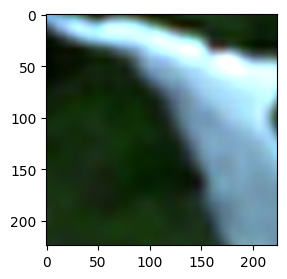

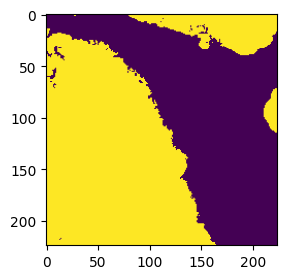

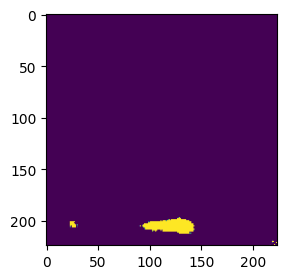

In [9]:
total_loss = 0
total_TP = 0
total_FP = 0
total_FN = 0
total_TN = 0

run.net.eval()
with torch.no_grad():
    for batch_idx, (sat, label) in enumerate(jamaica_loader):
        print(f"Batch {batch_idx + 1}/{len(jamaica_loader)}", end="\r")
        sat = sat.to(DEVICE)
        label = label.float().to(DEVICE)

        # encode
        if len(sat.shape) == 3:
            sat = sat.unsqueeze(0)
        sat_x1 = run.net.encoder(sat)
        
        # diffuse
        sat_xs, sat_pred_x0s = run.ddpm_sampling(opt, sat_x1, clip_denoise=opt.clip_denoise, verbose=False)
        sat_x0_hat = sat_pred_x0s[:, -1].to(DEVICE)

        # decode
        label_hat = run.net.decoder(run.net.center(sat_x0_hat))

        # plot sat_img, gt label, label_hat
        if batch_idx == 0:
            idx = 17
            plot_img_gt_pred(sat[idx], label[idx], label_hat[idx], rgb_mean_tensor=RGB_MEANS_TENSOR, rgb_std_tensor=RGB_SDS_TENSOR, satellite_mean_tensor=SATELLITE_MEANS_TENSOR, satellite_std_tensor=SATELLITE_SDS_TENSOR)
            break
        
        loss = LOSS(label_hat, label)
        total_loss += loss.item()

        label_hat = torch.sigmoid(label_hat).view(-1)
        label = label.view(-1)

        TP = (label_hat * label).sum().item()
        FP = ((1 - label) * label_hat).sum().item()
        FN = (label * (1 - label_hat)).sum().item()
        TN = ((1 - label) * (1 - label_hat)).sum().item()

        total_TP += TP
        total_FP += FP
        total_FN += FN
        total_TN += TN

avg_loss = total_loss / len(jamaica_loader)
precision = total_TP / (total_TP + total_FP) if (total_TP + total_FP) > 0 else 0
recall = total_TP / (total_TP + total_FN) if (total_TP + total_FN) > 0 else 0
f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
iou = total_TP / (total_TP + total_FP + total_FN) if (total_TP + total_FP + total_FN) > 0 else 0
accuracy = (total_TP + total_TN) / (total_TP + total_FP + total_FN + total_TN) if (total_TP + total_FP + total_FN + total_TN) > 0 else 0
specificity = total_TN / (total_TN + total_FP) if (total_TN + total_FP) > 0 else 0


In [7]:
metrics = {
        'Loss': avg_loss,
        'Precision': precision,
        'Recall': recall,
        'f1_score': f1_score,
        'IOU': iou,
        'Accuracy': accuracy,
        'Specificity': specificity
    }

print(metrics)

{'Loss': 0.9864163994789124, 'Precision': 0.6258177319636755, 'Recall': 0.013755773329397558, 'f1_score': 0.026919835781706616, 'IOU': 0.013643559075751936, 'Accuracy': 0.5923130563759293, 'Specificity': 0.9942856034061185}


In [8]:
print(total_TP)
print(total_FP)
print(total_FN)
print(total_TN)

162981.80078125
97448.34118652344
11685265.25
16955680.46875
